# Template for parsing pdf tables to data in bulk

## set up environment

you should have a `requirements.txt` file with:

```
ipykernel
pandas
camelot-py
pypdf
poppler
beautifulsoup4
requests
```

on the terminal, run

`python -m venv .venv`

`.venv/Scripts/activate`

`pip install -r requirements.txt`

(or create a conda envoronment)

now select that `.venv` kernel to run this notebook and the following imports should work


In [1]:
import pandas as pd
import numpy as np
import camelot
import pypdf
import requests
from bs4 import BeautifulSoup
import re
import io
import warnings


## load a sample 

In [2]:
# url to a sample pdf

url = 'https://hhinternet.blob.core.windows.net/uploads/2023/03/report-for-the-week-of-february-20-2023-to-february-26-2023.pdf'

In [3]:
# it will be easiest if you supply the page number to start (note the page number is as a string)
# below we'll go through how to find the page number from table text

table = camelot.read_pdf(
    'report-for-the-week-of-march-20-2023-to-march-26-2023.pdf',
    pages='5',
    backend='poppler'
)

c:\Users\dlevine\Anaconda3\envs\camelot-pdf\lib\site-packages\camelot\utils.py:740: UserWarning:   (972.12, 974.61504) does not lie in column range (36.23999267578125, 971.88)
  warnings.warn(


In [4]:
table

# shows the number of tables parsed, should be the number of tables on the page

<TableList n=1>

In [5]:
table[0].parsing_report

{'accuracy': -81.77, 'whitespace': 10.91, 'order': 1, 'page': 5}

the `parsing report` may give a weird result and you may get a parsing warning, as in this example. but you can visually check the image parsing and see if it is working.  

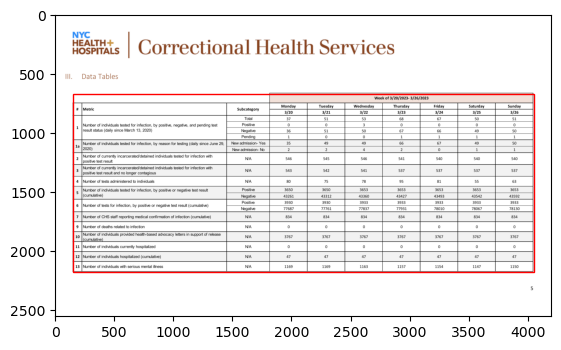

In [6]:
fig = camelot.plot(table[0], kind='contour')

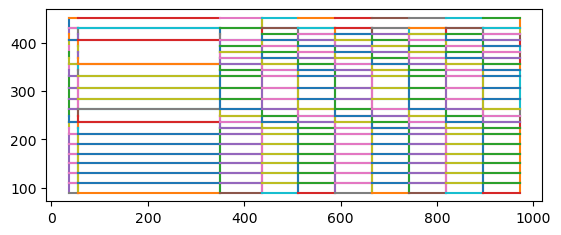

In [7]:
fig = camelot.plot(table[0], kind='grid')

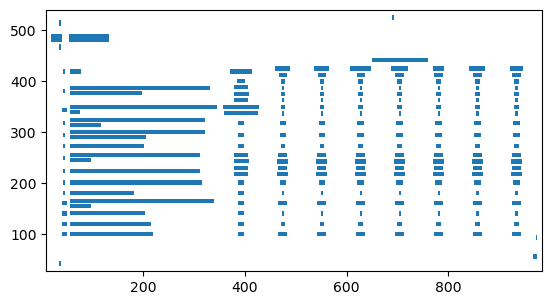

In [8]:
fig = camelot.plot(table[0], kind='text')

In [9]:
# since it is actually parsing the table just fine, we are going to supress that warning for now. careful doing this though.

warnings.filterwarnings('ignore',message='.* does not lie in column range')

### see how to parse it

This part has to be specific to the table you are working with. 

In [10]:
# see what you are working with

table[0].df

,0,1,2,3,4,5,6,7,8,9
0,,,,Week of 3/20/2023- 3/26/2023,,,,,,
1,#,Metric,Subcategory,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
2,,,,3/20,3/21,3/22,3/23,3/24,3/25,3/26
3,1,"Number of individuals tested for infection, by...",Total,37,51,53,68,67,50,51
4,,,Positive,0,0,3,0,0,0,0
5,,,Negative,36,51,50,67,66,49,50
6,,,Pending,1,0,0,1,1,1,1
7,1a,"Number of individuals tested for infection, by...",New admission- Yes,35,49,49,66,67,49,50
8,,,New admission- No,2,2,4,2,0,1,1
9,2,Number of currently incarcerated/detained indi...,N/A,546,545,546,541,540,540,540


string together pandas manipulations to get the data you want

In [11]:
# e.g. this to get the full table

data = (
    table[0].df
    .iloc[1:]
)

data.columns = list(data.iloc[0,:3]) + list(data.iloc[1,3:])

data = (
    data
    .drop(index=[1,2])
    .reset_index(drop=True)
    .replace('',np.nan)
    .ffill()
)

data

,#,Metric,Subcategory,3/20,3/21,3/22,3/23,3/24,3/25,3/26
0,1,"Number of individuals tested for infection, by...",Total,37,51,53,68,67,50,51
1,1,"Number of individuals tested for infection, by...",Positive,0,0,3,0,0,0,0
2,1,"Number of individuals tested for infection, by...",Negative,36,51,50,67,66,49,50
3,1,"Number of individuals tested for infection, by...",Pending,1,0,0,1,1,1,1
4,1a,"Number of individuals tested for infection, by...",New admission- Yes,35,49,49,66,67,49,50
5,1a,"Number of individuals tested for infection, by...",New admission- No,2,2,4,2,0,1,1
6,2,Number of currently incarcerated/detained indi...,N/A,546,545,546,541,540,540,540
7,3,Number of currently incarcerated/detained indi...,N/A,543,542,541,537,537,537,537
8,4,Number of tests administered to individuals,N/A,80,75,78,95,81,55,63
9,5,"Number of individuals tested for infection, by...",Positive,3650,3650,3653,3653,3653,3653,3653


In [ ]:
# or more usefully, this to get just the data you need

In [12]:
# get the row of data

data = (
    table[0].df
    .iloc[21, -7:]
    .astype(int)
)

# find the date by searching for numbers in the first row of the table (where the dates of the week are) 
# and creating a date object from the second date (end of week)

week_end_date = pd.to_datetime('-'.join(table[0].df.iloc[0].str.findall(r'\d+').max()[-3:]))

# check that the parsed date is a Sunday

assert week_end_date.day_of_week == 6, "error parsing the week end date"

# and then create a seven-day index from that

week_daterange = pd.date_range(end=week_end_date, periods=7, freq='D')

# and set the day index

data = data.set_axis(week_daterange)

data

2023-03-20    1169
2023-03-21    1169
2023-03-22    1163
2023-03-23    1157
2023-03-24    1154
2023-03-25    1147
2023-03-26    1150
Freq: D, Name: 21, dtype: int32

Because this and many tables in the wild are formatted with different levels of headings and columns, it's going to take some careful parsing to get the data you need. 

You'll probably need to use `.iloc` absolute references to arbitrary row and column indexes, but do be careful because if the format of the table changes, these absolute references will get thrown off. (like this fine specimen where the metric numbers are missing so the columns are all shifted left one: https://hhinternet.blob.core.windows.net/uploads/2022/07/report-for-the-week-of-june-20-2022-to-june-26-2022.pdf)

This example has all the data we need (the date and measure value) within the table, it just takes some searching and manipulation _of the table_ to get it. For other cases, you may need to get the date or labels from elsewhere in the pdf or from the file name.  See below for other ways to get that.

Next, make the parsing a function, adding appropriate `assert` checks that the data parsed is what is should be. 

This can be checking the data values (as here), or  types, or some other check. It's easiest of you can set some reasonable thresholds/guardrails from the outset, but you could also build up tests from the data, e.g. from the mean of previous weeks.

This will make the parsing fail on an error, but that is what we want for now. You'll likely need to refine this parsing function to make sure it handles all the actual tables correctly

In [13]:
# now make it a function


def parse_data(df):

    df = df.copy()

    data = (
        df
        .iloc[21, -7:]
        .astype(int)
        .rename('Number of individuals with serious mental illness')
    )

    # check that the data is plausible

    assert data.min() > 100 and data.max() < 10000, "parsed data values seem out of usual range"


    # find the week date by searching for numbers in the first row of the table (where the dates of the week are) 
    # and creating a date object from the second date (end of week)

    week_end_date = pd.to_datetime('-'.join(df.iloc[0].str.findall(r'\d+').max()[-3:]))

    # check that the parsed date is a Sunday

    assert week_end_date.day_of_week == 6, "error parsing the week end date"

    # and then create a seven-day index from that

    week_daterange = pd.date_range(end=week_end_date, periods=7, freq='D')

    # and set the day index

    data = data.set_axis(week_daterange)

    return data
    

## get links to all files

find the links on the webpage and filter to just the ones you need

In [14]:
# page with the links to pdf reports

url = 'https://www.nychealthandhospitals.org/correctionalhealthservices/publications-reports/'

In [ ]:
# get and parse that page

r = requests.get(url)
html_page = r.text
soup = BeautifulSoup(html_page, 'html.parser')

now add filter conditions to find the specific pdf links you are loooking for. 

(You can run this first getting _all_ pdf files and inspect the link text to find what you are looking for)

In [17]:
target_files = []

anchors = soup.find_all('a')

for a in anchors:
    a_href = a.get('href')
    if (
        isinstance(a_href,str) and 
        len(a_href) > 3 and 
        a_href[-3:] == 'pdf' and  # these first three filters will return all links to `.pdf` files
        'report-for-the-week-of-' in a_href # add any additional conditions to get just the reports you need
    ):
        target_files.append(a_href)

target_files

['https://hhinternet.blob.core.windows.net/uploads/2023/04/report-for-the-week-of-march-20-2023-to-march-26-2023.pdf',
 'https://hhinternet.blob.core.windows.net/uploads/2023/04/report-for-the-week-of-march-13-2023-to-march-19-2023.pdf',
 'https://hhinternet.blob.core.windows.net/uploads/2023/04/report-for-the-week-of-february-27-2023-to-march-5-2023.pdf',
 'https://hhinternet.blob.core.windows.net/uploads/2023/03/report-for-the-week-of-february-20-2023-to-february-26-2023.pdf',
 'https://hhinternet.blob.core.windows.net/uploads/2023/03/report-for-the-week-of-february-13-2023-to-february-19-2023.pdf',
 'https://hhinternet.blob.core.windows.net/uploads/2023/03/report-for-the-week-of-february-6-february-12-2023.pdf',
 'https://hhinternet.blob.core.windows.net/uploads/2023/02/report-for-the-week-of-january-29-february-5-2023.pdf',
 'https://hhinternet.blob.core.windows.net/uploads/2023/02/report-for-the-week-of-january-23-2023-to-january-29-2023.pdf.pdf',
 'https://hhinternet.blob.core.wi

these links are all absolute (beginning with `http://`), but you may find relative links, too.

you can prepend the root url with 

```py
import urllib

base_url = 'https://www.nyc.gov' # or whatever the root is

absolute_targets = [base_url + urllib.parse.quote(target) for target in target_files]
```

### parse dates or labels from file names

You may need to extract a date or other label from these file names.

If you are sure the files are in order and at a regular cadance you can create an index.

This doesn't apply for this example but for another example with quarterly files, this could work:

```py
date_target = {date:target for date, target in zip([f'{year}-Q{q}' for year in range(2017, 2023) for q in range(1,5)][:-2],quarter_files)}
```

if you're sure they follow a consistent pattern you can parse the text with string manipulations, something like this

In [18]:
def parse_date_from_file_name(file):

    return ' '.join(
        file
        .split('report-for-the-week-of-')
        [-1]
        .rstrip('.pdf')
        .replace('-',' ')
        .title()
        .split()
        [-3:]
    )

In [19]:
date_targets = {parse_date_from_file_name(file):file for file in target_files}

date_targets

{'March 26 2023': 'https://hhinternet.blob.core.windows.net/uploads/2023/04/report-for-the-week-of-march-20-2023-to-march-26-2023.pdf',
 'March 19 2023': 'https://hhinternet.blob.core.windows.net/uploads/2023/04/report-for-the-week-of-march-13-2023-to-march-19-2023.pdf',
 'March 5 2023': 'https://hhinternet.blob.core.windows.net/uploads/2023/04/report-for-the-week-of-february-27-2023-to-march-5-2023.pdf',
 'February 26 2023': 'https://hhinternet.blob.core.windows.net/uploads/2023/03/report-for-the-week-of-february-20-2023-to-february-26-2023.pdf',
 'February 19 2023': 'https://hhinternet.blob.core.windows.net/uploads/2023/03/report-for-the-week-of-february-13-2023-to-february-19-2023.pdf',
 'February 12 2023': 'https://hhinternet.blob.core.windows.net/uploads/2023/03/report-for-the-week-of-february-6-february-12-2023.pdf',
 'February 5 2023': 'https://hhinternet.blob.core.windows.net/uploads/2023/02/report-for-the-week-of-january-29-february-5-2023.pdf',
 'January 29 2023': 'https://hh

but be careful because atypical file names will throw this off

In [20]:
list(date_targets.keys())[96:103]

['April 25 2021',
 'April 18 2021',
 'April 11 2021',
 '4 2021 608B5A4B399Fb',
 'March 28 2021',
 'March 21 2021',
 'March 14 2021']

a careful regex search might do better.

In [21]:
def regex_parse_date_from_file_name(file):

    month = re.findall('(jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)', file)[-1].title()

    day = re.findall('\-\d+\-',file)[-1].strip('-')

    year = re.findall('\-20\d+',file)[-1].strip('-')

    return ' '.join([month, day, year])

In [22]:
date_targets = {regex_parse_date_from_file_name(file):file for file in target_files}

date_targets

{'Mar 26 2023': 'https://hhinternet.blob.core.windows.net/uploads/2023/04/report-for-the-week-of-march-20-2023-to-march-26-2023.pdf',
 'Mar 19 2023': 'https://hhinternet.blob.core.windows.net/uploads/2023/04/report-for-the-week-of-march-13-2023-to-march-19-2023.pdf',
 'Mar 5 2023': 'https://hhinternet.blob.core.windows.net/uploads/2023/04/report-for-the-week-of-february-27-2023-to-march-5-2023.pdf',
 'Feb 26 2023': 'https://hhinternet.blob.core.windows.net/uploads/2023/03/report-for-the-week-of-february-20-2023-to-february-26-2023.pdf',
 'Feb 19 2023': 'https://hhinternet.blob.core.windows.net/uploads/2023/03/report-for-the-week-of-february-13-2023-to-february-19-2023.pdf',
 'Feb 12 2023': 'https://hhinternet.blob.core.windows.net/uploads/2023/03/report-for-the-week-of-february-6-february-12-2023.pdf',
 'Feb 5 2023': 'https://hhinternet.blob.core.windows.net/uploads/2023/02/report-for-the-week-of-january-29-february-5-2023.pdf',
 'Jan 29 2023': 'https://hhinternet.blob.core.windows.net

if you're counting on these dates, it's probably a good idea to add an `assert` check in here, too.

### parse dates or labels from file contents

instead of the file slugs, you can also extract date or label text from the text of the pdf report.

In [23]:
sample_target = date_targets['Jul 11 2021']
sample_target

'https://hhinternet.blob.core.windows.net/uploads/2021/07/report-for-the-week-of-july-05-2021-to-july-11-2021.pdf'

In [24]:
# get page, open pdf, get title page text

r = requests.get(sample_target)

pdf_object = io.BytesIO(r.content)

reader = pypdf.PdfReader(stream=pdf_object)

first_page = reader.pages[0]

first_page_text = first_page.extract_text()

# find months, days, years. select the last one.

month = re.findall('(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)', first_page_text)[-1].title()

day = re.findall('\ \d+\,',first_page_text)[-1].strip(', ')

year = re.findall('20\d+',first_page_text)[-1]

# combine to a date object

print('-'.join([month,day,year]))

end_of_week_date = pd.to_datetime('-'.join([month,day,year]))

end_of_week_date

Jul-11-2021


Timestamp('2021-07-11 00:00:00')

## loop and parse all

ok! party time. Go through all the files, extract the data, and concat it all together.

Note this is there you are going to find surprise errors when there are pdfs, tables, file names etc that don't exactly conform to your samples.

So use the error messages to see which files are causing problems and go back and adjust the functions accordingly. Doing this iteratively in a notebook is going to be the way to go until you are sure you are capturing what you need.

In [26]:
all_weeks_data_list = []

search_text = "Number of individuals with serious mental illness"

for date,target in date_targets.items():

    # find what page the table is on (this this pdf open you could also extract other information from the text as above)

    r = requests.get(target)

    pdf_object = io.BytesIO(r.content)

    reader = pypdf.PdfReader(stream=pdf_object)

    total_pages = len(reader.pages)

    pages_with_search_text = []

    for page_number in range(total_pages):
        page_object = reader.pages[page_number]
        page_text = page_object.extract_text()
        
        if re.search(search_text,page_text):
            pages_with_search_text.append(page_number)

    if not pages_with_search_text:
        warnings.warn(f"text not found in pdf for {date} (from {target})")
        continue

    table_page_number = pages_with_search_text[-1] + 1     # +1 because these pages are zero-indexed 

    try:
        table = camelot.read_pdf(
            target, 
            pages=str(table_page_number),
            backend='poppler'
        )

        week_data = parse_data(table[0].df)

    except (IndexError, ValueError):
        warnings.warn(f"error extracting table {date} (from {target})")
        continue

    all_weeks_data_list.append(week_data)

all_weeks_data = pd.concat(all_weeks_data_list)

C:\Users\dlevine\AppData\Local\Temp\ipykernel_20656\225069629.py:27: UserWarning: text not found in pdf for Aug 14 2022 (from https://hhinternet.blob.core.windows.net/uploads/2022/09/report-for-the-week-of-august-8-2022-to-august-14-2022.pdf)
  warnings.warn(f"text not found in pdf for {date} (from {target})")


In [27]:
all_weeks_data

2023-03-20    1169
2023-03-21    1169
2023-03-22    1163
2023-03-23    1157
2023-03-24    1154
              ... 
2020-07-01     664
2020-07-02     663
2020-07-03     659
2020-07-04     657
2020-07-05     661
Name: Number of individuals with serious mental illness, Length: 966, dtype: int32

One more checks on the data before we call it success.

Check for suplicate index values.

In [28]:
all_weeks_data.index.duplicated().any()

True

In [29]:
all_weeks_data[all_weeks_data.index.duplicated(keep=False)].sort_index()

2022-06-20    972
2022-06-20    972
2022-06-21    977
2022-06-21    977
2022-06-22    983
2022-06-22    983
2022-06-23    986
2022-06-23    986
2022-06-24    985
2022-06-24    985
2022-06-25    980
2022-06-25    980
2022-06-26    979
2022-06-26    979
Name: Number of individuals with serious mental illness, dtype: int32

we got a week twice, but at least the numbers extracted are the same in each instance

In [30]:
all_weeks_data_dedup = (
    all_weeks_data
    .sort_index()
    .reset_index()
    .drop_duplicates(subset='index')
    .rename(columns={'index':'Date'})
    .set_index('Date')
)

all_weeks_data_dedup

,Number of individuals with serious mental illness
Date,
2020-06-29,669
2020-06-30,664
2020-07-01,664
2020-07-02,663
2020-07-03,659
...,...
2023-03-22,1163
2023-03-23,1157
2023-03-24,1154


Of course add additional relevant checks on the data here, too. 

And since what we really want is month data, you can easily reaggregate the daily values to monthly

In [31]:
(
    all_weeks_data_dedup
    .resample('M')
    .mean()
)

,Number of individuals with serious mental illness
Date,
2020-06-30,666.500000
2020-07-31,671.806452
2020-08-31,679.322581
2020-09-30,727.233333
2020-10-31,756.354839
2020-11-30,756.166667
2020-12-31,783.645161
2021-01-31,825.806452
2021-02-28,847.857143


In [32]:
# or whatever other aggregation you need e.g.

(
    all_weeks_data_dedup
    .resample('M')
    .agg(['mean', 'median','sum','max'])
)

Number of individuals with serious mental illness                  
                                                        mean  median    sum   
Date                                                                          
2020-06-30                                        666.500000   666.5   1333  \
2020-07-31                                        671.806452   671.0  20826   
2020-08-31                                        679.322581   679.0  21059   
2020-09-30                                        727.233333   727.0  21817   
2020-10-31                                        756.354839   756.0  23447   
2020-11-30                                        756.166667   755.5  22685   
2020-12-31                                        783.645161   784.0  24293   
2021-01-31                                        825.806452   825.0  25600   
2021-02-28                                        847.857143   843.5  23740   
2021-03-31                                        895.870968   891.0  27772   
2021-04-30                                        954.766667   957.0  28643   
2021-05-31                                        960.096774   955.0  29763   
2021-06-30                                        952.700000   953.0  28581   
2021-07-31                                        957.645161   958.0  29687   
2021-08-31                                        957.032258   957.0  29668   
2021-09-30                                        921.933333   929.0  27658   
2021-10-31                                        872.354839   872.0  27043   
2021-11-30                                        854.333333   854.5  25630   
2021-12-31                                        842.838710   842.0  26128   
2022-01-31                                        852.870968   842.0  26439   
2022-02-28                                        886.178571   885.5  24813   
2022-03-31                                        905.483871   906.0  28070   
2022-04-30                                        912.900000   916.0  27387   
2022-05-31                                        926.129032   926.0  28710   
2022-06-30                                        961.233333   966.0  28837   
2022-07-31                                       1002.833333  1002.5  24068   
2022-08-31                                       1032.833333  1033.0  24788   
2022-09-30                                       1061.066667  1062.5  31832   
2022-10-31                                       1075.117647  1075.0  18277   
2022-11-30                                       1107.733333  1106.0  33232   
2022-12-31                                       1112.800000  1114.0  27820   
2023-01-31                                       1153.033333  1154.0  34591   
2023-02-28                                       1163.964286  1165.0  32591   
2023-03-31                                       1158.894737  1163.0  22019   

                  
             max  
Date              
2020-06-30   669  
2020-07-31   690  
2020-08-31   692  
2020-09-30   753  
2020-10-31   775  
2020-11-30   768  
2020-12-31   805  
2021-01-31   842  
2021-02-28   876  
2021-03-31   930  
2021-04-30   978  
2021-05-31   978  
2021-06-30   964  
2021-07-31   975  
2021-08-31   975  
2021-09-30   962  
2021-10-31   890  
2021-11-30   874  
2021-12-31   863  
2022-01-31   881  
2022-02-28   903  
2022-03-31   925  
2022-04-30   927  
2022-05-31   935  
2022-06-30   986  
2022-07-31  1023  
2022-08-31  1049  
2022-09-30  1084  
2022-10-31  1120  
2022-11-30  1132  
2022-12-31  1125  
2023-01-31  1186  
2023-02-28  1184  
2023-03-31  1178